## Setup

In [ ]:
!pip uninstall torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y
!pip install torch==2.5.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install torch-geometric --no-cache-dir
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib --no-cache-dir --find-links https://data.pyg.org/whl/torch-2.5.0+cu124.html

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:0

## Step 1: Data Loading & Preprocessing
Before training any model, it’s crucial to bring structure and consistency to the dataset. The following script:

- Loads the cleaned PrimeKG CSV file,

- Applies Unicode normalization to ensure consistent formatting across biomedical terms,

- Maps the diverse node types (e.g., "gene/protein", "chemical/drug") to standardized categories.

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import unicodedata
import networkx as nx
import numpy as np
from torch_geometric.utils import from_networkx
from torch_geometric.data import HeteroData
from torch_geometric.nn import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Data
df = pd.read_csv("/content/drive/MyDrive/filtered_primekg.csv",
                 dtype={"x_name": str, "y_name": str, "relation": str, "x_type": str, "y_type": str},
                 low_memory=False)

print(f"[INFO] Data Loaded: {df.shape[0]} rows")

# Normalize Text Formatting
def clean_text(text):
    return unicodedata.normalize("NFKD", str(text)).strip().lower()

df["x_name"] = df["x_name"].apply(clean_text)
df["y_name"] = df["y_name"].apply(clean_text)

# Fix Node Type Mapping
node_type_mapping = {
    "gene/protein": "protein",
    "chemical/drug": "drug",
    "drug": "drug",
    "disease": "disease",
    "biological_process": "bioprocess",
    "bioprocess": "bioprocess",
    "pathway": "pathway",
    "effect/phenotype": "phenotype"
}

df["x_type"] = df["x_type"].map(node_type_mapping)
df["y_type"] = df["y_type"].map(node_type_mapping)

# Print Unique Relationships and Their Counts
print("\n [INFO] Relationship Counts:")
relation_counts = df["relation"].value_counts()
for relation, count in relation_counts.items():
    print(f"   {relation}: {count} edges")

[INFO] Data Loaded: 1803896 rows

 [INFO] Relationship Counts:
   protein_protein: 642150 edges
   disease_phenotype_positive: 300634 edges
   bioprocess_protein: 289610 edges
   disease_protein: 160822 edges
   drug_effect: 129568 edges
   pathway_protein: 85292 edges
   disease_disease: 64388 edges
   contraindication: 61350 edges
   drug_protein: 51306 edges
   indication: 18776 edges


## Step 2: Extracting Nodes and Relationship Types
Once the data is normalized, the next step is to organize the graph into nodes and edges based on their types. This ensures the knowledge graph is ready for modeling in frameworks like PyTorch Geometric.

What's happening here?

- Node Sets:
For each node type (e.g., "protein", "disease", "drug"), we collect all unique node names appearing as either a source (x_name) or a target (y_name) in the graph. This gives us a complete set of nodes grouped by type.

- Relation Map:
The code then iterates through each unique relationship in the dataset (e.g., treats, causes, interacts_with) and identifies the source and target node types for that relation. These are stored in a dictionary (relation_map) for later use during graph construction.

In [ ]:
# Extract Node Sets
node_sets = {t: set() for t in node_type_mapping.values()}
for t in node_sets.keys():
    x_nodes = set(df[df["x_type"] == t]["x_name"].dropna().unique())
    y_nodes = set(df[df["y_type"] == t]["y_name"].dropna().unique())
    node_sets[t] = x_nodes | y_nodes

# Extract Relations
relation_map = {}
actual_relations = set(df["relation"].unique())

for rel in actual_relations:
    x_type = df[df["relation"] == rel]["x_type"].iloc[0]
    y_type = df[df["relation"] == rel]["y_type"].iloc[0]
    if x_type in node_type_mapping.values() and y_type in node_type_mapping.values():
        relation_map[rel] = (x_type, y_type)

## Step 3: Constructing the Undirected Graph
To prepare the data for node embedding models like Node2Vec, an undirected graph is built using NetworkX. This graph reflects the underlying biomedical knowledge structure from the CSV dataset.

What's happening in the code?

1. Node Index Mapping (node_maps):
Each node is assigned a unique integer ID, organized by type (e.g., diseases, proteins, drugs). This allows efficient reference during graph construction.

2. Adding Edges:
For each relation in the dataset (e.g., treats, causes), the code:

- Extracts the source and destination node types.

- Maps each entity name to its corresponding index.

- Filters out any missing nodes (-1).

- Adds only valid edges to the graph.


In [ ]:
# Construct Undirected Graph
G = nx.Graph()
node_maps = {k: {name: i for i, name in enumerate(sorted(v))} for k, v in node_sets.items()}

for rel, (src_type, dst_type) in relation_map.items():
    rel_df = df[df['relation'] == rel]
    src_indices = [node_maps[src_type].get(x, -1) for x in rel_df['x_name']]
    dst_indices = [node_maps[dst_type].get(y, -1) for y in rel_df['y_name']]

    valid_edges = [(s, d) for s, d in zip(src_indices, dst_indices) if s != -1 and d != -1]

    if valid_edges:
        G.add_edges_from(valid_edges)

print("\n [INFO] Relationship Counts Printed Successfully!")


 [INFO] Relationship Counts Printed Successfully!


### Raw Node Distribution (Before Embedding)

Before diving into Node2Vec, it's important to understand the starting point. The plot below shows a random scatter of all nodes in the graph, colored by their type (e.g., protein, drug, disease, etc.). Since these coordinates are untrained and purely random, there’s no structure yet — all node types are chaotically mixed.

This baseline helps contrast what happens **after** we apply Node2Vec, where the learned embeddings reveal meaningful groupings, semantic patterns, and structural clusters.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

def plot_raw_node_distribution(node_maps, embedding_dim=2, seed=42):
    """
    Plots a raw scatter of node positions before embedding training.
    Each node is assigned a random position (simulating 'unstructured' space)
    and colored by node type.
    """
    np.random.seed(seed)

    all_nodes = []
    all_types = []

    for ntype, mapping in node_maps.items():
        n = len(mapping)
        coords = np.random.rand(n, embedding_dim)  # random 2D positions
        df = pd.DataFrame(coords, columns=["x", "y"])
        df["type"] = ntype
        all_nodes.append(df)

    all_df = pd.concat(all_nodes, ignore_index=True)

    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=all_df,
        x="x", y="y",
        hue="type",
        palette="Set2",
        s=35, alpha=0.8, edgecolor="white", linewidth=0.3
    )
    plt.title("Raw Node Distribution by Type (Pre-Embedding)", fontsize=14)
    plt.xlabel("Random X")
    plt.ylabel("Random Y")
    plt.legend(title="Node Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


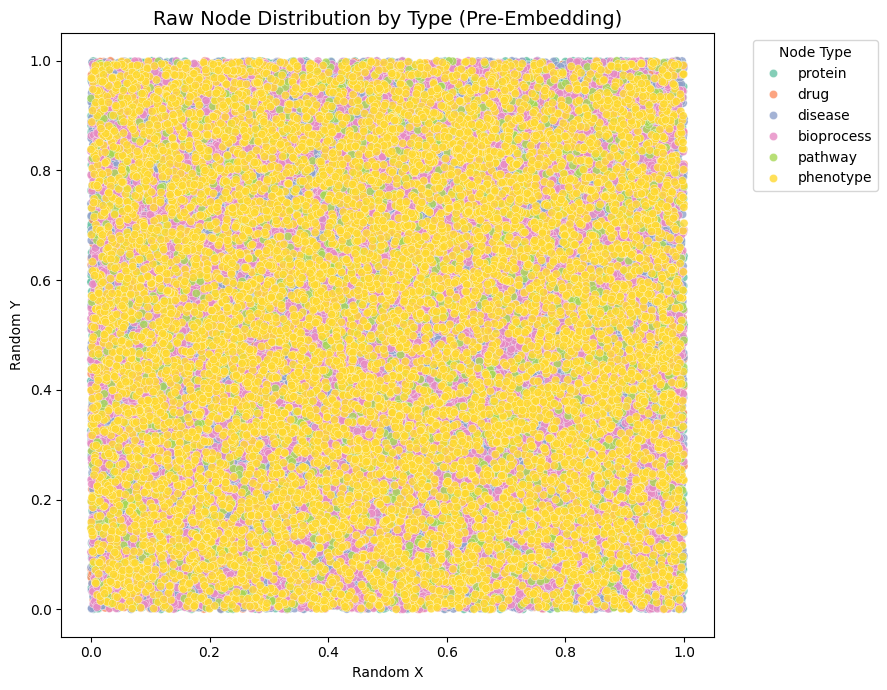

In [ ]:
plot_raw_node_distribution(node_maps, embedding_dim=2, seed=42)

## Training Node2Vec embeddings

# Step 4: Training Node2Vec Embeddings with Edge Sampling
After constructing the biomedical graph, the next goal is to learn low-dimensional embeddings that preserve both structural and semantic similarity between entities. This is done using Node2Vec, a method that captures node neighborhoods via biased random walks.

What does this code do?

# Graph Conversion:
The NetworkX graph is converted to a PyTorch Geometric (PyG) format using from_networkx(), and transferred to GPU (if available).

Node2Vec Setup:

A Node2Vec model is initialized with:

- 128-dimensional embeddings

- Biased random walks of length 10

- Context window of size 5

- 20 walks per node

- 1 negative sample per training example

Training Strategy:

- Randomly sample edges and corresponding nodes.

- Generate positive and negative random walks.

- Use contrastive loss: make positive walks closer and negatives farther.

- Monitor validation loss and apply early stopping (patience = 200).




In [ ]:
# Convert to PyG format & move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pyg_graph = from_networkx(G)
pyg_graph.edge_index = pyg_graph.edge_index.to(device)

# Node2Vec setup
node2vec = Node2Vec(
    pyg_graph.edge_index,
    embedding_dim=128,
    walk_length=10,
    context_size=5,
    walks_per_node=20,
    num_negative_samples=1
).to(device)

node2vec.rowptr = node2vec.rowptr.to(device)
node2vec.col = node2vec.col.to(device)

# Set Hyperparameters
batch_size = 256
patience = 200
epochs_no_improve = 0
best_loss = float("inf")

# Train-Validation Edge Split
edge_index = pyg_graph.edge_index
num_edges = edge_index.shape[1]
train_edges, val_edges = train_test_split(np.arange(num_edges), test_size=0.1, random_state=42)
train_edges = torch.tensor(train_edges, device=device)
val_edges = torch.tensor(val_edges, device=device)

optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.0025)

print("[INFO] Training Node2Vec embeddings with edge sampling...")
for epoch in range(10000):
    optimizer.zero_grad()
    batch_indices = train_edges[torch.randint(0, train_edges.size(0), (batch_size,), device=device)]
    batch_nodes = edge_index[:, batch_indices].view(-1).unique()
    pos_rw = node2vec.pos_sample(batch_nodes)
    neg_rw = node2vec.neg_sample(batch_nodes)
    loss = node2vec.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer.step()

    node2vec.eval()
    with torch.no_grad():
        val_batch_indices = val_edges[torch.randint(0, val_edges.size(0), (batch_size,), device=device)]
        val_batch_nodes = edge_index[:, val_batch_indices].view(-1).unique()
        val_pos_rw = node2vec.pos_sample(val_batch_nodes)
        val_neg_rw = node2vec.neg_sample(val_batch_nodes)
        val_loss = node2vec.loss(val_pos_rw, val_neg_rw)

    print(f"Epoch {epoch + 1}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(node2vec.embedding.weight.data.clone().cpu(), "best_node2vec_embeddings.pt")
        print(f"[INFO] New Best Loss: {best_loss:.4f} → Saving Embeddings...")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"[INFO] Early Stopping Triggered after {epoch + 1} epochs")
        break

print("\n [INFO] Node2Vec Training with Edge Sampling Completed!")

## Step 5:Disease-Phenotype Link Prediction using Logistic Regression

Once the Node2Vec embeddings are trained, the next task is to predict potential links in the graph — specifically, between diseases and phenotypes, or any other entity types.

This is achieved using a Logistic Regression model trained on edge features derived from node embeddings.

What does the code do?

- Positive Samples:
All existing edges of a given relation (e.g., "disease_phenotype_positive") are collected as positive training examples.

- Negative Sampling:
Randomly sampled node pairs (that don’t form a real edge) are used as negative examples, ensuring the model learns to differentiate between real and fake links.

- Feature Construction:
For each node pair:

Multiply embeddings (u * v) and sum across dimensions to get a single similarity score per edge.

These scores form the feature matrix X.

 Model Training:

- Logistic Regression is trained using a train_test_split.

- class_weight="balanced" ensures the model is robust to imbalanced classes.

- Evaluation:

Key metrics include:Accuracy, Precision, Recall, F1 Score, ROC-AUC for probabilistic discrimination

In [ ]:
# Load trained embeddings
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

embeddings = torch.load("best_node2vec_embeddings.pt")

def evaluate_link_prediction(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\nEvaluating {src_type.title()} ↔ {tgt_type.title()} Link Prediction for relation: {relation_name}")

    # Positive edges
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]]
        .values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    src_nodes = list(node_sets[src_type])
    tgt_nodes = list(node_sets[tgt_type])

    pos_edges = np.array([
        [node_maps[src_type][x], node_maps[tgt_type][y]]
        for x, y in relation_edges
        if x in node_maps[src_type] and y in node_maps[tgt_type]
    ])

    # Negative samples
    num_samples = len(pos_edges)
    neg_edges = np.array([
        [node_maps[src_type][random.choice(src_nodes)],
         node_maps[tgt_type][random.choice(tgt_nodes)]]
        for _ in range(num_samples)
    ])

    # Embedding features
    pos_features = (embeddings[pos_edges[:, 0]] * embeddings[pos_edges[:, 1]]).sum(dim=1)
    neg_features = (embeddings[neg_edges[:, 0]] * embeddings[neg_edges[:, 1]]).sum(dim=1)

    X = torch.cat([pos_features, neg_features]).numpy()
    y = np.array([1] * len(pos_features) + [0] * len(neg_features))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X.reshape(-1, 1), y, test_size=0.2, random_state=42
    )

    model = LogisticRegression(class_weight="balanced")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print("\nPrediction Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Show top-k predicted links
    similarity_scores = model.decision_function(X_test.reshape(-1, 1))
    top_indices = np.argsort(similarity_scores)[-top_k:]

    print(f"\nSample Predicted {src_type.title()} ↔ {tgt_type.title()} Links:")
    for idx in top_indices:
        if idx < len(neg_edges):
            src_idx, tgt_idx = neg_edges[idx]
            src_name = [k for k, v in node_maps[src_type].items() if v == src_idx][0]
            tgt_name = [k for k, v in node_maps[tgt_type].items() if v == tgt_idx][0]
            print(f"{src_name} ↔ {tgt_name}")

    # Score for a specific pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"...")
    if node1_name in node_maps[src_type] and node2_name in node_maps[tgt_type]:
        u = node_maps[src_type][node1_name]
        v = node_maps[tgt_type][node2_name]
        edge_feat = (embeddings[u] * embeddings[v]).sum().item()
        edge_score = model.predict_proba(np.array([[edge_feat]]))[:, 1][0]
        print(f"Predicted probability: {edge_score:.4f}")
    else:
        print("One or both nodes not found in the graph.")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }


<ipython-input-14-0badccf0e132>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("best_node2vec_embeddings.pt")


In [ ]:
evaluate_link_prediction(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



Evaluating Disease ↔ Phenotype Link Prediction for relation: disease_phenotype_positive

Prediction Metrics:
Accuracy:  0.5060
Precision: 0.5088
Recall:    0.4677
F1 Score:  0.4874
ROC-AUC:   0.5100

Sample Predicted Disease ↔ Phenotype Links:
disease of cell nucleus ↔ acute rhabdomyolysis
human african trypanosomiasis ↔ curved middle phalanx of the 4th toe
chloramphenicol toxicity ↔ hypoplasia of the antihelix
grid2-related autosomal dominant spinocerebellar ataxia ↔ midclavicular hypoplasia
seizures-scoliosis-macrocephaly syndrome ↔ marked delay in bone age
granulomatous slack skin disease ↔ hashimoto thyroiditis
craniometaphyseal dysplasia ↔ abnormal neutrophil count
ovarian mucinous adenocarcinoma ↔ slanting of the palpebral fissure
generalized basaloid follicular hamartoma syndrome ↔ brain neoplasm
atypical chronic myeloid leukemia, bcr-abl1 negative ↔ multifocal seizures

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"...
Predicted probability: 0.5018


{'accuracy': 0.505968122364377,
 'precision': 0.5087882307394502,
 'recall': 0.46765354779019286,
 'f1_score': 0.4873544463398353,
 'roc_auc': np.float64(0.5099767512730027)}

## Step 6: Link Prediction with XGBoost
While Logistic Regression provides a baseline, XGBoost brings the power of gradient boosting to this task — often yielding stronger performance on structured graph data.


Positive and Negative Sampling:

- Real edges (positive) are sampled from a target biomedical relation (e.g., disease-phenotype).

- Random fake edges (negative) are generated via node sampling.

Feature Engineering:

- Instead of dot product, embedding concatenation is used to retain rich relational structure.

- Positive and negative edge features are combined to form a full dataset X.

Model Training:

An XGBClassifier is trained with:

- n_estimators=200

- max_depth=5

- learning_rate=0.05

Tuned for stability with subsampling and colsampling.

Evaluation:

Predictions and probabilities are evaluated using:

Accuracy, Precision, Recall, F1 Score

ROC-AUC

In [ ]:
import xgboost as xgb
import random
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

def evaluate_with_xgboost(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {relation_name} with XGBoost...")

    # Step 1: Extract positive edges
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    src_nodes = list(node_sets[src_type])
    tgt_nodes = list(node_sets[tgt_type])

    pos_edges = np.array([
        [node_maps[src_type][x], node_maps[tgt_type][y]]
        for x, y in relation_edges
        if x in node_maps[src_type] and y in node_maps[tgt_type]
    ])

    if len(pos_edges) == 0:
        print(f"No positive edges found for: {relation_name}")
        return

    # Step 2: Negative sampling
    num_samples = len(pos_edges)
    neg_edges = np.array([
        [node_maps[src_type][random.choice(src_nodes)],
         node_maps[tgt_type][random.choice(tgt_nodes)]]
        for _ in range(num_samples)
    ])

    # Step 3: Feature extraction using concatenation
    pos_features = torch.cat([
        embeddings[pos_edges[:, 0]],
        embeddings[pos_edges[:, 1]]
    ], dim=1)

    neg_features = torch.cat([
        embeddings[neg_edges[:, 0]],
        embeddings[neg_edges[:, 1]]
    ], dim=1)

    X = torch.cat([pos_features, neg_features]).numpy()
    y = np.array([1] * len(pos_features) + [0] * len(neg_features))

    # Step 4: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 5: Train XGBoost classifier
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    model.fit(X_train, y_train)

    # Step 6: Evaluation
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] XGBoost Prediction Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 7: Prediction score for a specific pair
    print(f"\nScoring pair: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps[src_type] and node2_name in node_maps[tgt_type]:
        u = node_maps[src_type][node1_name]
        v = node_maps[tgt_type][node2_name]
        pair_feat = torch.cat([embeddings[u], embeddings[v]]).numpy().reshape(1, -1)
        score = model.predict_proba(pair_feat)[:, 1][0]
        print(f"Predicted probability: {score:.4f}")
    else:
        print("One or both nodes not found in node mappings.")

    # Step 8: Show top-k predicted links
    similarity_scores = probs
    top_indices = np.argsort(similarity_scores)[-top_k:]
    print(f"\nSample Predicted {src_type.title()} ↔ {tgt_type.title()} Links (XGBoost):")
    for idx in top_indices:
        if idx < len(neg_edges):
            u, v = neg_edges[idx]
            u_name = [k for k, val in node_maps[src_type].items() if val == u][0]
            v_name = [k for k, val in node_maps[tgt_type].items() if val == v][0]
            print(f"{u_name} ↔ {v_name}")

    # Step 9: Return metrics
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }


In [ ]:
evaluate_with_xgboost(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



[INFO] Evaluating disease_phenotype_positive with XGBoost...

[INFO] XGBoost Prediction Metrics:
Accuracy:  0.8275
Precision: 0.8833
Recall:    0.7565
F1 Score:  0.8150
ROC-AUC:   0.9064

Scoring pair: "permanent neonatal diabetes mellitus" ↔ "retinopathy"
Predicted probability: 0.4428

Sample Predicted Disease ↔ Phenotype Links (XGBoost):
primary pulmonary lymphoma ↔ increased level of platelet-activating factor
ceruminous carcinoma ↔ crumpled long bones
brachytelephalangy-dysmorphism-kallmann syndrome ↔ unilateral facial palsy
phencyclidine abuse ↔ genetic anticipation
middle ear neuroendocrine tumor ↔ retinal coloboma
c syndrome ↔ microspherocytosis
atrophic glossitis ↔ granulocytic hypoplasia
malakoplakia ↔ short toe
sialolithiasis ↔ papillary cystadenoma of the epididymis
le marec-bracq-picaud syndrome ↔ eeg with centrotemporal focal spike waves


{'accuracy': 0.8275319848474019,
 'precision': 0.8833208676140614,
 'recall': 0.7564586150451925,
 'f1_score': 0.8149823646679957,
 'roc_auc': np.float64(0.9063723845169356)}

## Step 7: Visualizing Learned Representations and Predictions
Once the Node2Vec embeddings are trained, several visualizations help make sense of the learned structure:

- Embedding Projection with t-SNE or PCA
To see how well the node embeddings capture structural or semantic distinctions, dimensionality reduction techniques like t-SNE or PCA are applied:

- t-SNE groups similar node types together based on their learned features.

Interpretation: Nodes with similar roles or relationships in the biomedical graph tend to cluster together in the embedding space.

- Top-K Predicted Links from ML Models
Using trained models like Logistic Regression or XGBoost, one can inspect the most confident predictions:


This lists top predicted edges between unconnected nodes.

Useful for identifying potential missing links in the knowledge graph.

- Cosine Similarity Heatmap of Selected Nodes
To explore relationships between specific biomedical entities, a cosine similarity heatmap can be plotted:

Helps quantify how semantically close diseases (or any node type) are in the embedding space.




In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# 4. t-SNE or PCA Projection of Embeddings (Improved Color Palette)
def plot_embedding_projection(embeddings, labels, method="tsne", title="Embedding Projection"):
    """
    Projects node embeddings into 2D space using t-SNE or PCA and visualizes them with enhanced colors.

    Parameters:
    - embeddings: numpy array or torch.Tensor
    - labels: list of categorical labels (e.g., node types)
    - method: 'tsne' or 'pca'
    - title: plot title
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Choose method as 'tsne' or 'pca'")

    if hasattr(embeddings, "cpu"):  # For torch.Tensor
        embeddings = embeddings.cpu().detach().numpy()

    reduced = reducer.fit_transform(embeddings)
    df = pd.DataFrame(reduced, columns=["x", "y"])
    df["label"] = labels

    plt.figure(figsize=(9, 7))
    pastel_palette = sns.color_palette("Set2")  # Better for categorical groups

    sns.scatterplot(
        data=df, x="x", y="y", hue="label",
        palette=pastel_palette, s=40, alpha=0.85, edgecolor="white", linewidth=0.4
    )

    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title="Node Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 5. Top-k Predicted Links

def show_topk_predicted_links(model, embeddings, node_maps, src_type, tgt_type, neg_edges, top_k=10):
    probs = model.predict_proba(
        torch.cat([
            embeddings[neg_edges[:, 0]],
            embeddings[neg_edges[:, 1]]
        ], dim=1).numpy()
    )[:, 1]

    top_indices = np.argsort(probs)[-top_k:]
    print(f"Top-{top_k} Predicted {src_type.title()} ↔ {tgt_type.title()} Links:")
    for idx in top_indices:
        u, v = neg_edges[idx]
        u_name = [k for k, val in node_maps[src_type].items() if val == u][0]
        v_name = [k for k, val in node_maps[tgt_type].items() if val == v][0]
        print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

# 6. Similarity Score Heatmap

def plot_similarity_heatmap(embeddings, selected_nodes, node_maps, node_type, title="Cosine Similarity Heatmap"):
    # Filter valid nodes that exist in node_maps
    valid_nodes = [n for n in selected_nodes if n in node_maps[node_type]]
    missing_nodes = [n for n in selected_nodes if n not in node_maps[node_type]]

    if missing_nodes:
        print(f"[WARNING] These nodes were skipped (not found in '{node_type}' mappings): {missing_nodes}")

    indices = [node_maps[node_type][n] for n in valid_nodes]
    selected_embeds = embeddings[indices]

    sim_matrix = torch.nn.functional.cosine_similarity(
        selected_embeds.unsqueeze(1), selected_embeds.unsqueeze(0), dim=2
    ).detach().numpy()

    df = pd.DataFrame(sim_matrix, index=valid_nodes, columns=valid_nodes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", square=True, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-23-37fa319d157f>:40: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(


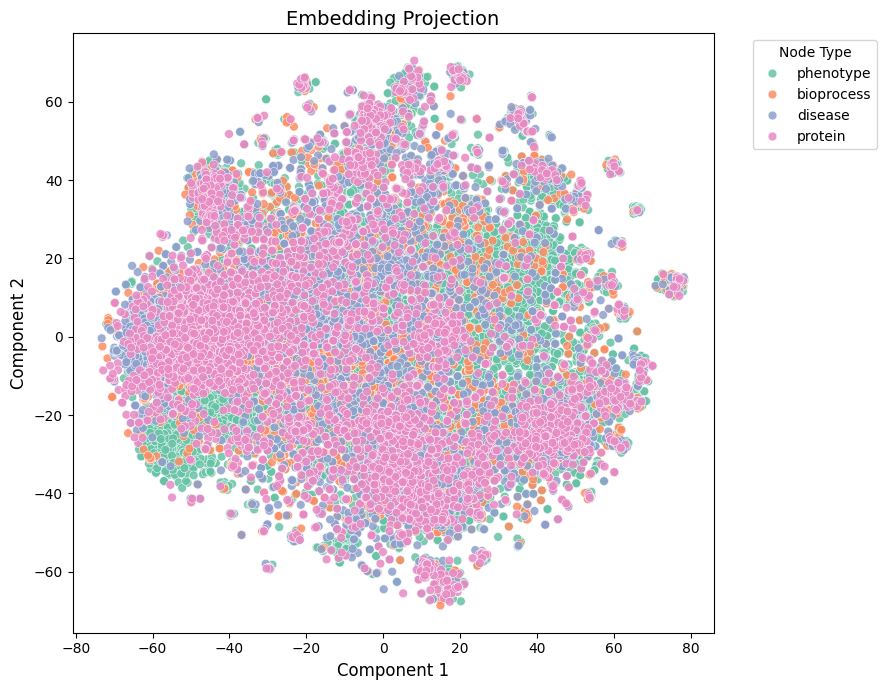

In [ ]:
# Create a list of node types aligned with embedding indices
labels = [None] * embeddings.shape[0]
for node_type, name_to_idx in node_maps.items():
    for name, idx in name_to_idx.items():
        labels[idx] = node_type
plot_embedding_projection(embeddings, labels)

[WARNING] These nodes were skipped (not found in 'disease' mappings): ['diabetes mellitus', 'leukemia', "alzheimer's disease", 'obesity']


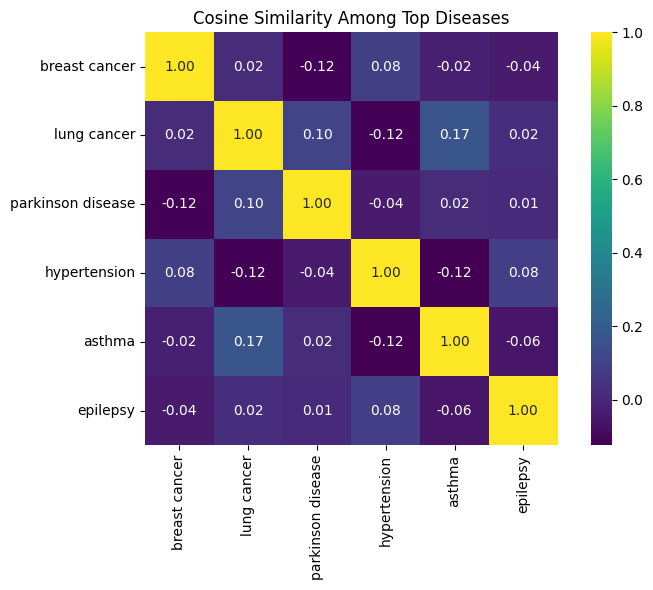

In [ ]:
selected_nodes = [
    "breast cancer",
    "lung cancer",
    "diabetes mellitus",
    "leukemia",
    "parkinson disease",
    "hypertension",
    "asthma",
    "epilepsy",
    "alzheimer's disease",
    "obesity"
]
plot_similarity_heatmap(
    embeddings=embeddings,
    selected_nodes=selected_nodes,
    node_maps=node_maps,
    node_type="disease",
    title="Cosine Similarity Among Top Diseases"
)


In [ ]:
results = []

metrics_logreg = evaluate_link_prediction(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)
if metrics_logreg:
    results.append({'model': 'Logistic Regression', **metrics_logreg})

metrics_xgb = evaluate_with_xgboost(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)
if metrics_xgb:
    results.append({'model': 'XGBoost', **metrics_xgb})

# Clean up np.float64 to native float
for r in results:
    for key in r:
        if isinstance(r[key], np.generic):
            r[key] = float(r[key])

import pprint
pprint.pprint(results)




Evaluating Disease ↔ Phenotype Link Prediction for relation: disease_phenotype_positive

Prediction Metrics:
Accuracy:  0.5086
Precision: 0.5118
Recall:    0.4663
F1 Score:  0.4880
ROC-AUC:   0.5101

Sample Predicted Disease ↔ Phenotype Links:
retinal vasculitis ↔ crumpled ear
fungal infectious disease ↔ orotic acid crystalluria
cdg syndrome type 4 ↔ genital tract atresia
ataxia-tapetoretinal degeneration syndrome ↔ duplication of distal phalanx of toe
monosomy 22 ↔ scalp tenderness
keppen-lubinsky syndrome ↔ hyperchloremic acidosis
psph deficiency ↔ chronic disseminated intravascular coagulation
intellectual developmental disorder with gastrointestinal difficulties and high pain threshold ↔ metacarpal synostosis
frias syndrome ↔ axial malrotation of the kidney
squamous cell carcinoma of pancreas ↔ wheezing

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"...
Predicted probability: 0.5015

[INFO] Evaluating disease_phenotype_positive with XGBoost...

[INFO] XGBoost Pred